In [6]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from osgeo import gdal
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

from torchinfo import summary
import gc
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [9]:
from tqdm.auto import tqdm # progress bar
from timeit import default_timer as timer
def print_train_time(start:float,
                    end:float,
                    device: torch.device= None):
    total_time=end-start
    print(f"Train time on {device} : {total_time:.3f} seconds")
    return total_time



C:\Users\jfrancis\Anaconda3\envs\envAIPS\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
#conda install -c conda-forge gdal
#!pip install "C:/Users/jfrancis/Downloads/GDAL-3.4.3-cp39-cp39-win_amd64.whl"

     ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00


In [10]:
torch.cuda.is_available()

True

In [11]:
# Grab the paths to all of the images in the 20m buffer folder
inputPath1="../data/processed/cam-2016-25m" # 16011 files
inputPath2="../data/processed/cam-2020-25m" # 16011 files
inputPath3="../data/processed/glo-2018-25m" # 16011 files
inputPath4="../data/processed/glo-2021-25m" # 16011 files
inputPath5="../data/processed/oxf-2016-25m" # 16011 files
inputPath6="../data/processed/oxf-2019-25m" # 16011 files
folderpaths = [inputPath1,inputPath2,inputPath3,inputPath4,inputPath5,inputPath6]
filelist = []

# Load the images, and append them to a list.
for folder in folderpaths: 
    for filepath in os.listdir(folder):
        if filepath.endswith((".tif")):
            #print(filepath)
            tempfile=folder+'/{0}'.format(filepath)
            filelist.append(tempfile)

In [12]:
len(filelist) # 107305 files

107305

In [13]:
# Grab the paths to all of the images in the 20m buffer folder
inputPath1="../data/processed/cam-2016-100m" 
inputPath2="../data/processed/cam-2020-100m" 
inputPath3="../data/processed/glo-2018-100m" 
inputPath4="../data/processed/glo-2021-100m" 
inputPath5="../data/processed/oxf-2016-100m" 
inputPath6="../data/processed/oxf-2019-100m" 
folderpaths = [inputPath1,inputPath2,inputPath3,inputPath4,inputPath5,inputPath6]
filelist_100m = []

# Load the images, and append them to a list.
for folder in folderpaths: 
    for filepath in os.listdir(folder):
        if filepath.endswith((".tif")):
            #print(filepath)
            tempfile=folder+'/{0}'.format(filepath)
            filelist_100m.append(tempfile)

In [14]:
len(filelist_100m) # 105441 files

106802

In [7]:
filelist_100m[7]

'../data/processed/cam-2016-100m/cambdrige-100m-point-1005.tif'

In [15]:
# Create a list with all of the images as arrays -
images = []

# Generate data
for i, ID in enumerate(filelist):
    # Store sample
    dataset = gdal.Open(ID)
    image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
    images.append(image)  # Append the NumPy array to the list.
    if i>2:
        break

In [16]:
images[0].shape

(3, 200, 200)

In [17]:
# Make images into on big array and then transpose for use in ML model
all_data= np.stack(images, axis= 0)
#all_data = np.transpose(all_data, axes=[0, 2, 3, 1])
# normalize values of the input data to 0,1
all_data = all_data/255
all_data.shape

(4, 3, 200, 200)

In [ ]:
plt.imshow(np.transpose(all_data, axes=[0, 2, 3, 1])[0])

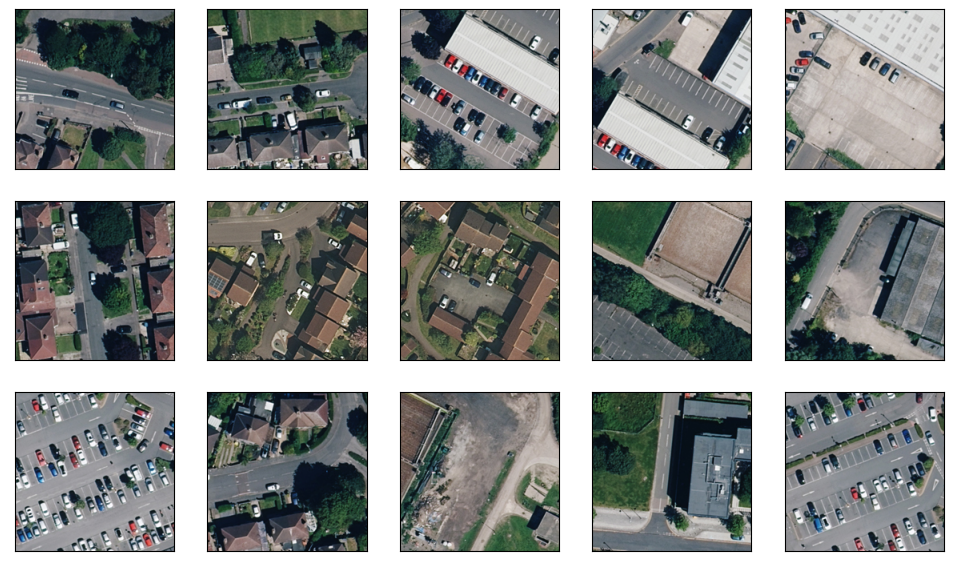

In [22]:
# function to display images
def display(array1, array2, array3):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    indices = np.random.choice(len(array1), size=n, replace=False)
    images2 = array2[indices]
    indices = np.random.choice(len(array1), size=n, replace=False)
    images3 = array3[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(np.transpose(image1, axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(np.transpose(image2, axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(5, n, i + 1 + n + n)
        plt.imshow(np.transpose(image3, axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

display(all_data,all_data,all_data)

In [6]:
# # lets take like 500 images, split into train/test and then see what a basic autoencoder can do
# device = "cuda" if torch.cuda.is_available() else "cpu"
# data_subset =all_data[:500]
# data_subset= torch.tensor(data_subset).to(device)
# data_subset.shape

In [7]:
# # split up the data into train/val
# np.random.seed(14)
# mask = torch.rand(len(data_subset)) <=.7

# training_data = torch.clone(data_subset)[mask]
# val_data = torch.clone(data_subset)[~mask]

# # # create train/test splits
# # from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(data_subset,data_subset,test_size=.3,random_state=42)

In [50]:
# training_data.shape , val_data.shape

(torch.Size([1405, 3, 160, 160]), torch.Size([595, 3, 160, 160]))

In [100]:
gc.collect()

1710

In [8]:
from sklearn.model_selection import train_test_split

filelist_train ,filelist_test = train_test_split(filelist,test_size=0.25,random_state=42) 

In [9]:
len(filelist_train), len(filelist_test)

(80478, 26827)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Create a DataLOader for my data
class rgb25mdataset_train(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_train, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_train           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image[np.isnan(image)] = 0
        image = image/255

        return image
    
class rgb25mdataset_test(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_test, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_test           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image[np.isnan(image)] = 0
        image = image/255

        return image
    
my_dataset_train = rgb25mdataset_train(filelist_train=filelist)
my_dataset_test = rgb25mdataset_test(filelist_test=filelist)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=20,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=20,shuffle=False, num_workers=0)

In [11]:
# len(my_dataset_train),len(my_dataset_test)

# Now try a CAE

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.InstanceNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(64),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(128),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(64),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(32),
#            nn.MaxPool2d(2, stride=2),
#             nn.Conv2d(32,32,kernel_size=3,padding=1),
#             nn.LeakyReLU(True),
            )
        self.decoder = nn.Sequential(
 #           nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
  #          nn.ReflectionPad2d(1),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'), #align_corners=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(64),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(128),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(),
            #nn.InstanceNorm2d(64),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32,3,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.Sigmoid())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    
torch.manual_seed(42)
#cae_1 = CAE()#.to(device)
cae_1 = Autoencoder().to(device)
cae_1, summary(cae_1,input_size= (1,3,200,200))

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.01)
     (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): LeakyReLU(negative_slope=0.01)
     (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): LeakyReLU(negative_slope=0.01)
     (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (10): LeakyReLU(negative_slope=0.01)
     (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (12): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): LeakyReLU(negative_slope=0.01)
     (14):

In [13]:
#help(nn.Upsample())
len(my_dataloader_train)

5366

In [37]:
gc.collect()

0

In [14]:
# make sure the shape is what we want
next(iter(my_dataloader_train))[1].shape

torch.Size([3, 200, 200])

In [15]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), '../data/models/all_25m_best_model_07022023.pt')

save_best_model = SaveBestModel()

In [16]:
# Can run a Train/Test Loop now
# Loss Function
loss_fn = nn.MSELoss() # sigmoid activation function built in
#loss_fn = nn.L1Loss() # maybe try this out?

# Opitimiser
optimizer = optim.Adam(params=cae_1.parameters(),
                     lr=.001,
                      weight_decay=1e-5)

# calculate mae (how clsoe are pixels to correct?)
def mae_fn(y_true,y_pred):
    mae = torch.abs((y_true-y_pred)).sum()
    return mae



# Build the training Loop (and a testing loop)

# Loop through the data
# forward pass (data moving thorugh models forward fucntions)
# Calculate loss (compare forwrard pass predictions to labels)
# Optimizer zero gradient
# Loss backward - move backwards to calculate the gradients of each parameter with respect to the loss
# Optimizer step - update weights to try and improve the loss (graident descent)
torch.manual_seed(42)
epochs = 25
# # track various values
# epoch_count= []
# loss_values= []
# test_loss_values= []
# test_accuracy= []
# train_accuracy= []

# put data on target device (device agnostic code)
# training_data=training_data.to(device)
# val_data=val_data.to(device)

# Instatiate datasets/loaders
my_dataset_train = rgb25mdataset_train(filelist_train=filelist[:500])
my_dataset_test = rgb25mdataset_test(filelist_test=filelist[:500])

my_dataloader_train = DataLoader(my_dataset_train, batch_size=20,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=20,shuffle=False, num_workers=0)

batch_size= 20

train_time_start_on_cpu = timer()
# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} out of {epochs}")
    train_loss = 0
    
    # Loop through training batch data
    for i_batch, sample_batched in enumerate(my_dataloader_train):
        X = sample_batched.to(device)
        X = Variable(X.float().cuda())
        cae_1.train()
        # Forward Pass
        y_pred = cae_1(X)
        
        # Calc loss (per batch)
        loss = loss_fn(y_pred, X)  # loss tested against itself
        train_loss += loss # accumulate train loss
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # perform backpropagation on the loss
        loss.backward()
        
        # performm gradient descent
        optimizer.step()
        
        if i_batch % 200 == 0:
            print(f"Batch {i_batch+1} out of {len(my_dataloader_train)} completed.")
            
    # Divide total train loss by length of dataloader
    train_loss /= (len(my_dataset_train)/batch_size)
        
    ### Testing
    test_loss, test_mae = 0,0
    
    cae_1.eval()
    with torch.inference_mode():
         for i_batch, sample_batched in enumerate(my_dataloader_test):
            X = sample_batched.to(device)
            X = Variable(X.float().cuda())
            # Forward pass
            test_pred = cae_1(X)
            
            # loss accumulate
            test_loss += loss_fn(test_pred,X)
            
            #Accuracy accumulate
            test_mae += mae_fn(y_true=X, y_pred=test_pred)
         
         # get loss per batch
         test_loss /= (len(my_dataset_test)/batch_size)
         
         # get mae per batch
         test_mae /= (len(my_dataset_test)/batch_size)
        
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_mae:.2f}")
#    save_best_model(test_loss, epoch, cae_1)


train_time_end_on_cpu = timer()    
total_train_time_on_cpu= print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(cae_1.parameters()).device))

# 157783.14 MAE
# 1 epoch 40201.82 855.967 seconds
# 5 epochs 35617.16 5221.646 seconds 

Epoch 1 out of 25


AssertionError: Torch not compiled with CUDA enabled

In [41]:
# m = nn.Upsample(size=[10,10], mode='nearest')
# b = nn.ReflectionPad2d(3)
# #b(m(torch.rand((10,5,5)))).shape,m(torch.rand((10,5,5))).shape 
# m(torch.rand((1,10,5,5))).shape 
# torch.save(cae_1.state_dict(),"../data/models/cae_25m.pt") # currently with 5 epochs
gc.collect()

59380

In [23]:
# my_dataset_train = rgb25mdataset_train(filelist_train=filelist)
# my_dataset_test = rgb25mdataset_test(filelist_test=filelist)
# my_dataloader_train = DataLoader(my_dataset_train, batch_size=25,shuffle=True, num_workers=0)
# my_dataloader_test = DataLoader(my_dataset_test, batch_size=25,shuffle=False, num_workers=0)

In [12]:
# see how well the images are predicted by the model
cae_1.eval()
with torch.inference_mode():
    X = next(iter(my_dataloader_test))
    X = X.to(device)
    X = Variable(X.float().cuda())
    test_pred = cae_1(X)

In [13]:
test_pred[0].shape

torch.Size([3, 200, 200])

In [14]:
len(X)

20

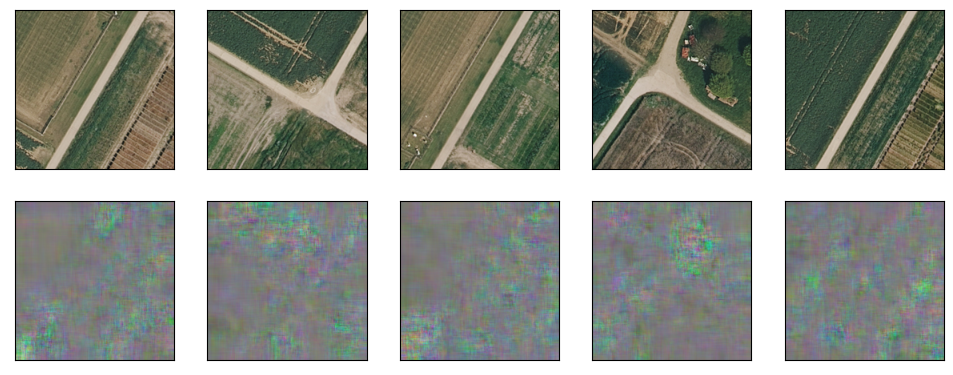

In [16]:
def display2(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(np.transpose(image1.cpu(), axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(np.transpose(image2.cpu(), axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()
#display2(X, test_pred)

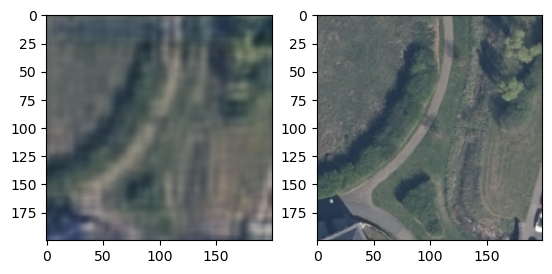

In [56]:
# ax = plt.subplot(1,2,1)
# plt.imshow(np.transpose(test_pred.cpu(), axes=[0, 2, 3, 1])[2])

# ax = plt.subplot(1,2,2)
# plt.imshow(np.transpose(X.cpu(), axes=[0, 2, 3, 1])[2])

In [17]:
cae_1.state_dict()

OrderedDict([('encoder.0.weight',
              tensor([[[[ 0.1471,  0.1597, -0.0451],
                        [ 0.1768, -0.0422,  0.0388],
                        [-0.0937,  0.1130,  0.1697]],
              
                       [[-0.1412,  0.1673,  0.0360],
                        [ 0.1422,  0.0261,  0.0928],
                        [-0.0272,  0.1484,  0.0284]],
              
                       [[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]]],
              
              
                      [[[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]],
              
                       [[-0.0841,  0.1111,  0.0344],
                      

In [38]:
#cae_1.load_state_dict(torch.load("../data/models/all_25m_best_model.pt"))
cae_1.load_state_dict(torch.load("../data/models/all_100m_best_model.pt"))


<All keys matched successfully>

In [39]:
my_dataset_train = rgb25mdataset_train(filelist_train=filelist_100m)
my_dataset_test = rgb25mdataset_test(filelist_test=filelist_100m)
# my_dataset_train = rgb25mdataset_train(filelist_train=filelist)
# my_dataset_test = rgb25mdataset_test(filelist_test=filelist)
my_dataloader_train = DataLoader(my_dataset_train, batch_size=25,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=25,shuffle=False, num_workers=0)

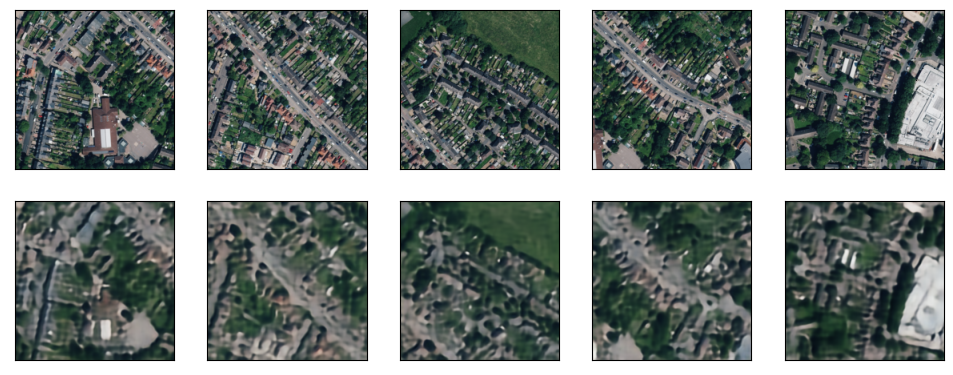

In [40]:
cae_1.eval()
with torch.inference_mode():
    X = next(iter(my_dataloader_test))
    X = X.to(device)
    X = Variable(X.float().cuda())
    test_pred = cae_1(X)
display2(X, test_pred)

In [42]:
len(my_dataloader_test)

4273

In [24]:
25*4293, len(filelist)

(107325, 107305)

In [43]:
%%time
# using just the encoding layers, get the image features... for now just of the test set..
prediction_list=[]
cae_1.eval()
with torch.inference_mode():
    for i_batch, sample_batched in enumerate(my_dataloader_test):
        X = sample_batched.to(device)
        X = Variable(X.float().cuda())
        test_pred = cae_1.encoder(X)
        prediction_list.append(test_pred.cpu())

CPU times: total: 1h 51min 37s
Wall time: 15min 8s


In [44]:
len(prediction_list)

4273

In [46]:
prediction_list[0].shape

torch.Size([25, 32, 12, 12])

In [47]:
# stack the items in the list and then flatten to get one row of features per image
arr = np.vstack(prediction_list)
arr = arr.reshape(-1,4608)
arr.shape

(106802, 4608)

In [49]:
# convert to df
df = pd.DataFrame(arr)
df["file_path"] = filelist_100m
df.head(-10)

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,file_path
0,0.911795,0.441321,-0.355157,-0.417011,-0.092765,-0.181833,-0.383090,-0.362801,-0.234860,-0.182240,...,1.311811,0.522979,0.274962,0.245334,0.227461,-0.188994,-0.030085,-0.161627,1.046340,../data/processed/cam-2016-100m/cambdrige-100m...
1,0.609838,-0.076251,-0.121947,-0.128930,-0.221825,-0.155405,0.023663,0.012616,-0.570346,-0.686401,...,-0.488942,-0.531798,-0.520897,-0.564383,-0.534146,-0.538225,-0.476308,-0.542823,0.556238,../data/processed/cam-2016-100m/cambdrige-100m...
2,1.020411,0.220884,-0.194644,-0.425885,-0.072917,-0.491776,0.430336,0.075121,0.185001,0.428238,...,0.285317,-0.113714,0.622094,0.658526,0.573371,0.122765,0.354988,-0.426727,0.689813,../data/processed/cam-2016-100m/cambdrige-100m...
3,0.460497,-0.688193,-0.340546,-0.642333,-0.702716,-0.498071,-0.578488,-0.520463,-0.488193,-0.539284,...,-0.479530,0.201724,0.286219,0.076118,0.039008,0.608537,0.542758,1.012149,0.603759,../data/processed/cam-2016-100m/cambdrige-100m...
4,1.129195,-0.244409,-0.622428,-0.404173,-0.364859,-0.599431,-0.561386,-0.421454,-0.601443,-0.588146,...,0.934738,0.152076,-0.211419,-0.041325,-0.390919,0.679428,0.535037,-0.102337,0.707369,../data/processed/cam-2016-100m/cambdrige-100m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106787,0.299175,0.019606,-0.210521,-0.319642,-0.028468,-0.274397,0.057253,0.150341,-0.044129,-0.325197,...,0.415133,0.142426,0.169052,-0.223783,0.180814,0.369559,0.118966,0.705276,1.464904,../data/processed/oxf-2019-100m/oxford-100m-po...
106788,0.470580,-0.189075,0.100608,-0.010243,-0.260125,0.052652,-0.046335,-0.248195,-0.160734,0.098875,...,0.640630,0.910533,0.083110,0.342670,-0.287401,-0.450520,-0.433652,0.895863,0.787441,../data/processed/oxf-2019-100m/oxford-100m-po...
106789,0.505922,-0.256041,-0.088418,-0.324405,-0.229243,-0.013207,-0.174556,-0.379718,-0.279972,0.206077,...,1.038536,0.727748,-0.130061,0.273892,0.642560,0.273611,0.404658,-0.165230,0.591074,../data/processed/oxf-2019-100m/oxford-100m-po...
106790,0.735848,0.088988,0.414855,0.490531,0.163325,0.037916,-0.331508,0.188255,0.362337,-0.044570,...,0.124138,1.028883,0.554659,0.820553,0.702306,1.231122,0.978364,0.036197,1.207014,../data/processed/oxf-2019-100m/oxford-100m-po...


In [50]:
# save a df of the image features
df.to_csv("../data/processed/image-features/cae-100m-features-19-12-22.csv")

# Now i need to do the same thing with the 100m images

In [13]:
len(filelist_100m)

106802

In [104]:
# filelist_train_100m ,filelist_test_100m = train_test_split(filelist_100m[:25000],test_size=0.25) 
# len(filelist_train_100m),len(filelist_test_100m)

(18750, 6250)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Create a DataLOader for my data
class rgb25mdataset_train(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_100m, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_100m           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image = image/255

        return image
    
class rgb25mdataset_test(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_100m, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_100m           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image = image/255

        return image
    
my_dataset_train = rgb25mdataset_train(filelist_100m=filelist_100m)
my_dataset_test = rgb25mdataset_test(filelist_100m=filelist_100m)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=20,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=20,shuffle=True, num_workers=0)

In [12]:
len(my_dataloader_train),len(my_dataloader_test)

(5341, 5341)

In [15]:
class Autoencoder_100m(nn.Module):
    def __init__(self):
        super(Autoencoder_100m,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64,32,kernel_size=3,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(2, stride=2),
#             nn.Conv2d(32,32,kernel_size=3,padding=1),
#             nn.LeakyReLU(True),
            )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'), #align_corners=True),

            #nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(128),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.GELU(),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.GELU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32,3,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.Sigmoid())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    
torch.manual_seed(42)
#cae_1 = CAE()#.to(device)
cae_100m = Autoencoder_100m().to(device)
cae_100m, summary(cae_100m,input_size= (1,3,200,200))

(Autoencoder_100m(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): GELU(approximate='none')
     (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): GELU(approximate='none')
     (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): GELU(approximate='none')
     (9): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): GELU(approximate='none')
     (12): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (13): MaxPool2d(kernel_size=2, stride

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), '../data/models/all_100m_best_model.pt')

save_best_model = SaveBestModel()

In [17]:
# Can run a Train/Test Loop now
# Loss Function
loss_fn = nn.MSELoss() # sigmoid activation function built in
#loss_fn = nn.L1Loss() # maybe try this out?

# Opitimiser
optimizer = optim.Adam(params=cae_100m.parameters(),
                     lr=.001,
                      weight_decay=1e-5)

# calculate mae (how clsoe are pixels to correct?)
def mae_fn(y_true,y_pred):
    mae = torch.abs((y_true-y_pred)).sum()
    return mae



# Build the training Loop (and a testing loop)

# Loop through the data
# forward pass (data moving thorugh models forward fucntions)
# Calculate loss (compare forwrard pass predictions to labels)
# Optimizer zero gradient
# Loss backward - move backwards to calculate the gradients of each parameter with respect to the loss
# Optimizer step - update weights to try and improve the loss (graident descent)
torch.manual_seed(42)
epochs = 1
# # track various values
# epoch_count= []
# loss_values= []
# test_loss_values= []
# test_accuracy= []
# train_accuracy= []

# put data on target device (device agnostic code)
# training_data=training_data.to(device)
# val_data=val_data.to(device)

# Instatiate datasets/loaders
my_dataset_train = rgb25mdataset_train(filelist_100m=filelist_100m)
my_dataset_test = rgb25mdataset_test(filelist_100m=filelist_100m)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=20,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=20,shuffle=False, num_workers=0)

batch_size= 20

train_time_start_on_cpu = timer()
# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} out of {epochs}")
    train_loss = 0
    
    # Loop through training batch data
    for i_batch, sample_batched in enumerate(my_dataloader_train):
        X = sample_batched.to(device)
        X = Variable(X.float().cuda())
        cae_100m.train()
        # Forward Pass
        y_pred = cae_1(X)
        
        # Calc loss (per batch)
        loss = loss_fn(y_pred, X)  # loss tested against itself
        train_loss += loss # accumulate train loss
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # perform backpropagation on the loss
        loss.backward()
        
        # performm gradient descent
        optimizer.step()
        
        if i_batch % 200 == 0:
            print(f"Batch {i_batch+1} out of {len(my_dataloader_train)} completed.")
            
    # Divide total train loss by length of dataloader
    train_loss /= (len(my_dataset_train)/batch_size)
        
    ### Testing
    test_loss, test_mae = 0,0
    
    cae_100m.eval()
    with torch.inference_mode():
         for i_batch, sample_batched in enumerate(my_dataloader_test):
            X = sample_batched.to(device)
            X = Variable(X.float().cuda())
            # Forward pass
            test_pred = cae_100m(X)
            
            # loss accumulate
            test_loss += loss_fn(test_pred,X)
            
            #Accuracy accumulate
            test_mae += mae_fn(y_true=X, y_pred=test_pred)
         
         # get loss per batch
         test_loss /= (len(my_dataset_test)/batch_size)
         
         # get mae per batch
         test_mae /= (len(my_dataset_test)/batch_size)
        
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_mae:.2f}")
#    save_best_model(test_loss, epoch, cae_100m)


train_time_end_on_cpu = timer()    
total_train_time_on_cpu= print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(cae_1.parameters()).device))

# 157783.14 MAE
# 1 epoch 40201.82 855.967 seconds
# 5 epochs 35617.16 5221.646 seconds 

Epoch 1 out of 1
Batch 1 out of 5341 completed.


KeyboardInterrupt: 

In [113]:
gc.collect()

1863